# Import libraries

In [1]:
import json
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt

# Example of data format for a single scan's MRIQC output

In [2]:
filepath = "./mriqc_output/sub-2332918_ses-NAPFU48_run-001_T1w.json"

with open(filepath, "r+") as file:
    data = json.load(file)
    del data['bids_meta']
    del data['provenance']
    pprint.pprint(data)

{'cjv': 0.4483252215563519,
 'cnr': 3.03588107158742,
 'efc': 0.5736794793449945,
 'fber': 3486.3879754136465,
 'fwhm_avg': 3.680683333333333,
 'fwhm_x': 3.75564,
 'fwhm_y': 3.75121,
 'fwhm_z': 3.5352,
 'icvs_csf': 0.23896913950456913,
 'icvs_gm': 0.41155280110393555,
 'icvs_wm': 0.34947805939149534,
 'inu_med': 0.7374693751335144,
 'inu_range': 0.2513059496879577,
 'qi_1': 5.195251898058409e-05,
 'qi_2': 0.004795732602123701,
 'rpve_csf': 26.88707975840483,
 'rpve_gm': 15.121849315940365,
 'rpve_wm': 20.11346722779336,
 'size_x': 176,
 'size_y': 240,
 'size_z': 256,
 'snr_csf': 1.833606415582332,
 'snr_gm': 8.892356395367713,
 'snr_total': 8.892254479555502,
 'snr_wm': 15.95080062771646,
 'snrd_csf': 6.761179797230499,
 'snrd_gm': 21.856357429069693,
 'snrd_total': 20.089224774479476,
 'snrd_wm': 31.65013709713823,
 'spacing_x': 1.0,
 'spacing_y': 1.0,
 'spacing_z': 1.0,
 'summary_bg_k': 2392.801813776368,
 'summary_bg_mad': 0.0,
 'summary_bg_mean': 11.696939497924124,
 'summary_bg_me

# Function to find discrepancies in NeuroCI's output file

In [3]:
NeuroCI_results_file = "Prevent-AD.json"

#Find a discrepancy between FSL and FreeSurfer hippocampal volumes for a given scan
def find_discrepancy(json_results, filename):
    with open(json_results, "r+") as file:
        data = json.load(file)
        FSL = float(data[filename]['FSL']['Result']['result'])
        FreeSurfer = float(data[filename]['FreeSurfer']['Result']['result'])
        return(abs(FSL-FreeSurfer))

#Example using the fn
find_discrepancy(NeuroCI_results_file, "sub-9748277_ses-NAPFU48_run-002_T1w.nii.gz")

1799.0

# Making a list of all such dictionaries available in the 'mriqc_output' directory

In [4]:
mriqc_output_directory = "./mriqc_output"
NeuroCI_results_file = "Prevent-AD.json"
list_of_mriqc = []

for filename in os.listdir(mriqc_output_directory):
    file_path = os.path.join(mriqc_output_directory, filename)
    with open(file_path, "r+") as file:
        data = json.load(file)
        del data['bids_meta']
        del data['provenance']
        data['filename'] = filename[:-5] + ".nii.gz" #Note that I added this so we know which result is of which scan.
        data['discrepancy'] = find_discrepancy(NeuroCI_results_file, data['filename']) #This is also added by me!
        list_of_mriqc.append(data)
        
pprint.pprint(list_of_mriqc[2]) #each element of the list is the dictionary of a single MRIQC result file.

{'cjv': 0.5616476701235894,
 'cnr': 2.416775913227449,
 'discrepancy': 531.3999999999996,
 'efc': 0.6229278830395136,
 'fber': 1807.1762688413487,
 'filename': 'sub-9125564_ses-PREEN00_run-001_T1w.nii.gz',
 'fwhm_avg': 3.316076666666666,
 'fwhm_x': 3.41443,
 'fwhm_y': 3.39818,
 'fwhm_z': 3.13562,
 'icvs_csf': 0.22179143477036378,
 'icvs_gm': 0.38938706749992763,
 'icvs_wm': 0.3888214977297086,
 'inu_med': 0.8012090921401978,
 'inu_range': 0.3443859577178955,
 'qi_1': 0.0,
 'qi_2': 0.0030501492914852607,
 'rpve_csf': 22.829297792515597,
 'rpve_gm': 12.325832190572076,
 'rpve_wm': 14.364282097106525,
 'size_x': 176,
 'size_y': 240,
 'size_z': 256,
 'snr_csf': 2.225539189635657,
 'snr_gm': 8.060183159915383,
 'snr_total': 7.478424097653104,
 'snr_wm': 12.149549943408273,
 'snrd_csf': 12.364301214863794,
 'snrd_gm': 33.734594465060646,
 'snrd_total': 31.401032510111026,
 'snrd_wm': 48.10420185040865,
 'spacing_x': 1.0,
 'spacing_y': 1.0,
 'spacing_z': 1.0,
 'summary_bg_k': 1237.31441944736

# List of all MRIQC features names

In [5]:
keys_not_to_include = ['discrepancy', 'filename']

features_list = [key for key in list_of_mriqc[0] if (not key in keys_not_to_include)]

# creating observations and target arrays

In [6]:
observations = list()
target = list()
for data in list_of_mriqc:
    x = list()
    for feature in features_list:
        x.append(data[feature])
    target.append(data['discrepancy'])
    observations.append(np.array(x))
            
observations = np.array(observations)
target = np.array(target)

removing bad features

In [7]:
# finding bad features
for i, feature in enumerate(features_list):
    if np.nan_to_num(np.std(observations[:,i]))==0:
        keys_not_to_include.append(feature)

    if np.sum(observations[:,i])==0:
        keys_not_to_include.append(feature)

# removing bad features from observations matrix
new_observations = list()
for i, feature in enumerate(features_list):
    if not feature in keys_not_to_include:
        new_observations.append(observations[:, i])
new_observations = np.array(new_observations).T
observations = new_observations

# removing bad features from features_list
for key in keys_not_to_include:
    if key in features_list:
        features_list.remove(key)


normalizing features and target

In [8]:
for i, feature in enumerate(features_list):
    observations[:, i] = observations[:, i] - np.mean(observations[:, i])
    observations[:, i] = np.divide(observations[:, i], np.std(observations[:, i]))

target = target - np.mean(target)
target = np.divide(target, np.std(target))

# finding top positively correlated features

In [9]:
N = 4 # number of top features to find

corr_list = list()
for i, feature in enumerate(features_list):
    corr_list.append(np.corrcoef(target, observations[:, i])[0,1])
corr_list = np.array(corr_list)
# max_i = np.argmax(np.abs(corr_list))
I = np.argsort(corr_list)
I = I[-N:]
top_features = [features_list[i] for i in I]
top_corrs = [corr_list[i] for i in I]
for i in range(N):
    print('correlation of feature -' + top_features[i] + '- with discrepancy = ', top_corrs[i])

correlation of feature -summary_wm_n- with discrepancy =  0.4861018225865463
correlation of feature -inu_med- with discrepancy =  0.49308206790544656
correlation of feature -inu_range- with discrepancy =  0.5084366824141152
correlation of feature -efc- with discrepancy =  0.6019287785632785


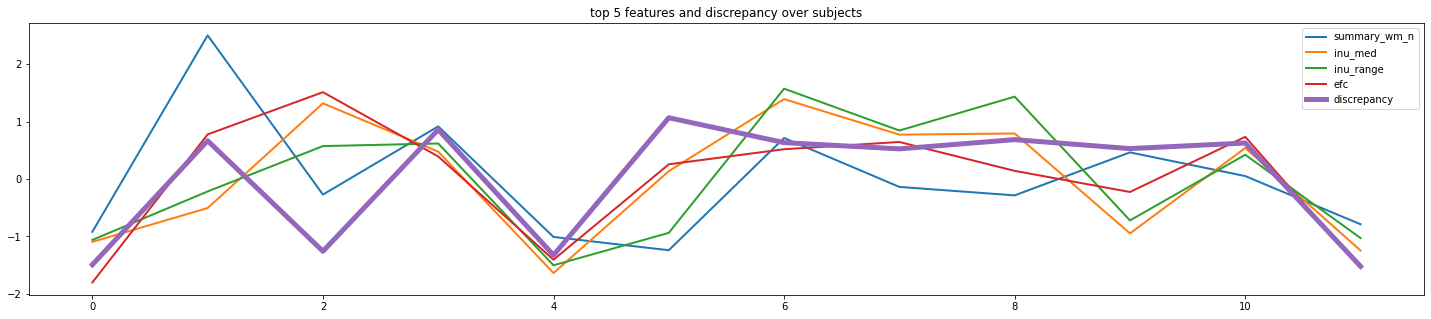

In [10]:
plt.figure(figsize=(25, 5))
for i in I:
    plt.plot(observations[:, i], label=features_list[i], linewidth=2)
plt.plot(target, label='discrepancy', linewidth=5)
plt.legend()
plt.title('top 5 features and discrepancy over subjects')
plt.show()